<a href="https://colab.research.google.com/github/pointerness/udacity_capstone/blob/master/Udacity_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data upload

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

## Upload Kaggle Data
source for importing data from kaggle into colab https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235

In [2]:
from google.colab import  files
files.upload()
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/

Saving kaggle.json to kaggle (2).json
kaggle.json


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
chicago/chicago-copa-cases                              Chicago COPA Cases                                  3MB  2019-04-05 00:00:32           1440  
himanshupoddar/zomato-bangalore-restaurants             Zomato Bangalore Restaurants                       88MB  2019-03-31 09:48:43           1811  
sfinspiredu/synchrotron-data-set                        Synchrotron Data Set                               10KB  2019-05-27 19:54:29            296  
crisparada/brazilian-cities                             Brazilian Cities                                  935KB  2019-05-24 20:49:21            923  
taniaj/australian-election-2019-tweets                  Australian Election 2019 Tweets             

In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls
!pwd

 creditcardfraud.zip  'kaggle (2).json'   sample_data
'kaggle (1).json'      kaggle.json
/content


# Data Exploration

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
data = pd.read_csv('/content/creditcardfraud.zip',compression='zip',header=0,sep=',',quotechar='"')

In [9]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


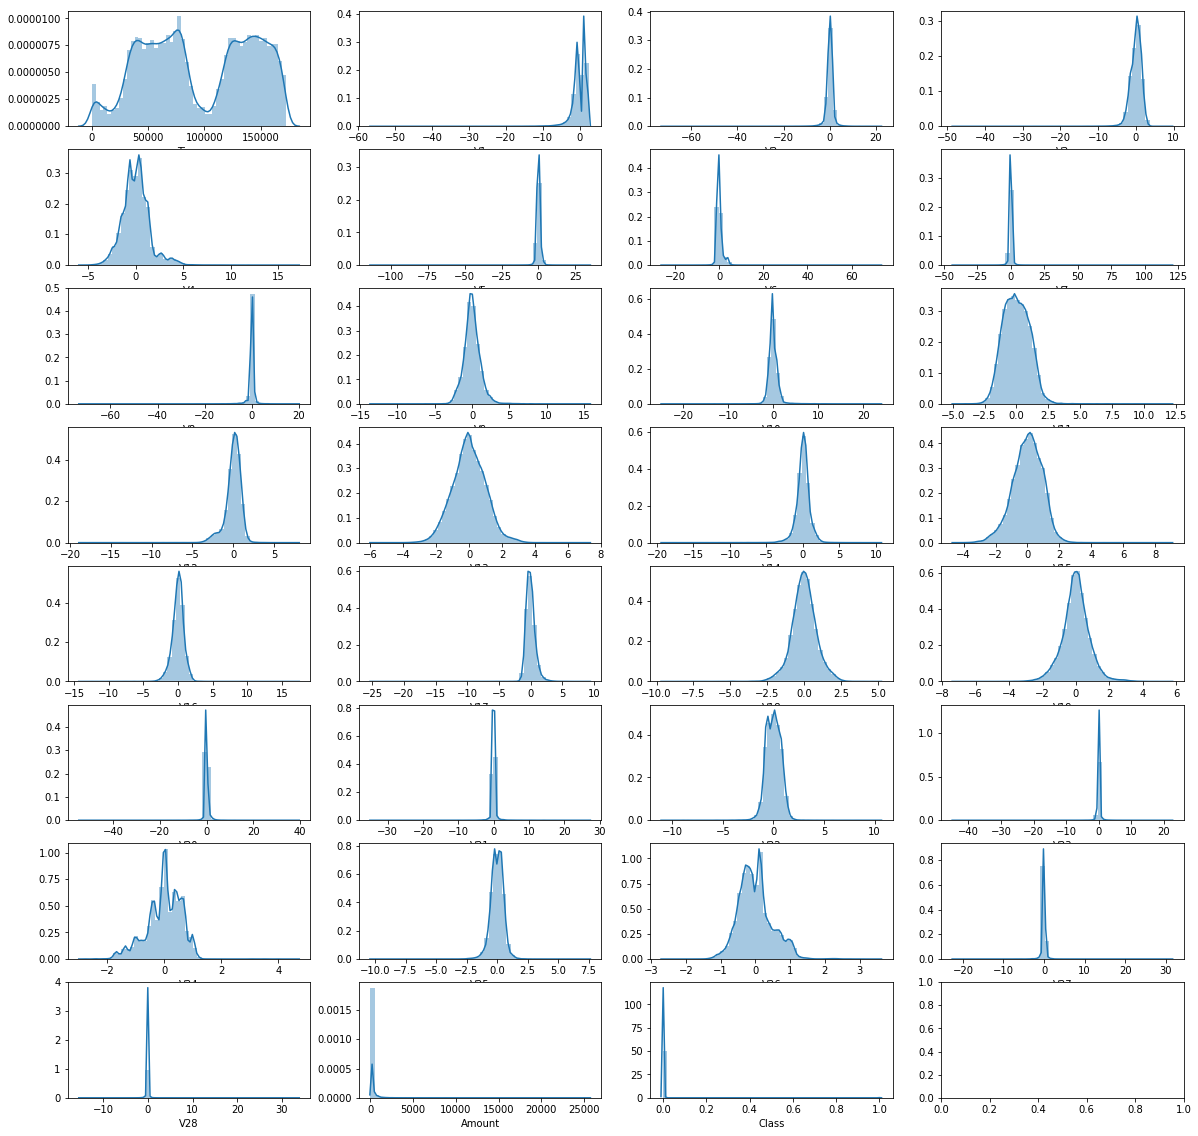

In [11]:
dims = (20, 20)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=dims)
for i, column in enumerate(data.columns):
    sns.distplot(data[column],ax=axes[i//4,i%4])

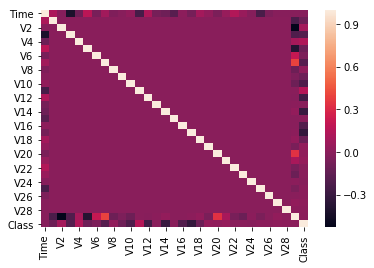

In [12]:
sns.heatmap(data.corr())

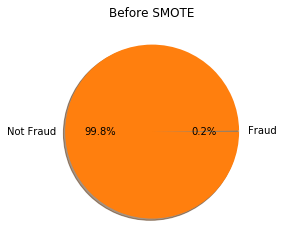

In [13]:
labels = ['Fraud', 'Not Fraud']
sizes = [data['Class'].value_counts()[1], data['Class'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Before SMOTE")
plt.show()

Only 0.2% of the total reported cases is Fraud.
Any model trained on this data will be biased to to classify as Not-Fraud. 
There is a chance that we have false Negatives in our prediction. Our target is to minimize the false negatives as much as possible.
The next few sections we will deal with the imbalance in data

Let's first analyse the Amount column. There is a significant difference between the mean and maximum values. Indicating there are outliers in the data. Especially given the standard deviation.
We have to scale the data so as to evaluate. We would prefer a scaler which gives us a normal distribution

In [14]:
display(data.Amount.describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

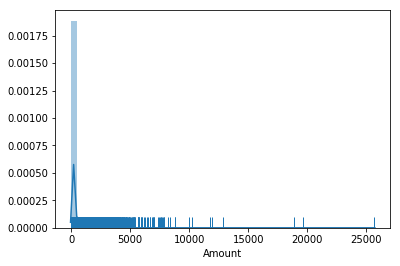

In [15]:
x = data.Amount
sns.distplot(x,hist=True, rug=True,kde=True);

The dataset has aready been feature engineered and normalised for executing algorithms.<br>
The Amount column  however needs to be normalized. 

##Normalize Amount Column

In [0]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

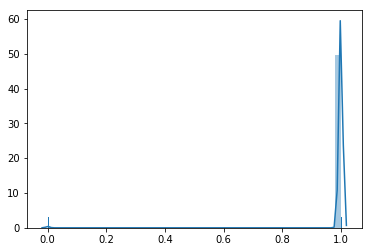

In [17]:
sns.distplot( Normalizer().fit_transform(data['Amount'].values.reshape(-1,1)),hist=True, rug=True,kde=True);

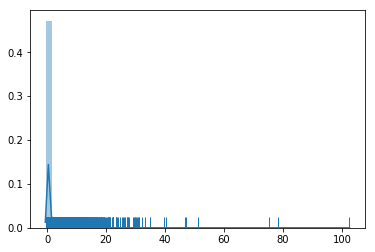

In [18]:
sns.distplot(StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1)),hist=True, rug=True,kde=True)

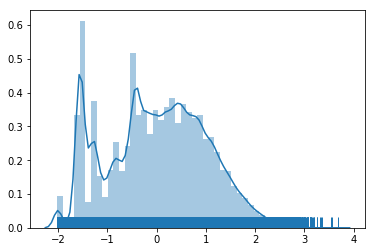

In [19]:
sns.distplot(PowerTransformer().fit_transform(data['Amount'].values.reshape(-1,1)),hist=True, rug=True,kde=True)

After evaluating three scaling techniques , we will go with the PowerTransformer option.
To understand different scaling techniques, 
refer https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [20]:

data['normalizedAmount'] = PowerTransformer().fit_transform(data['Amount'].values.reshape(-1,1))
normalizedData = data.drop(['Time','Amount'],axis=1)
normalizedData.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.119013
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.128464
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.623286
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.012504
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.692981


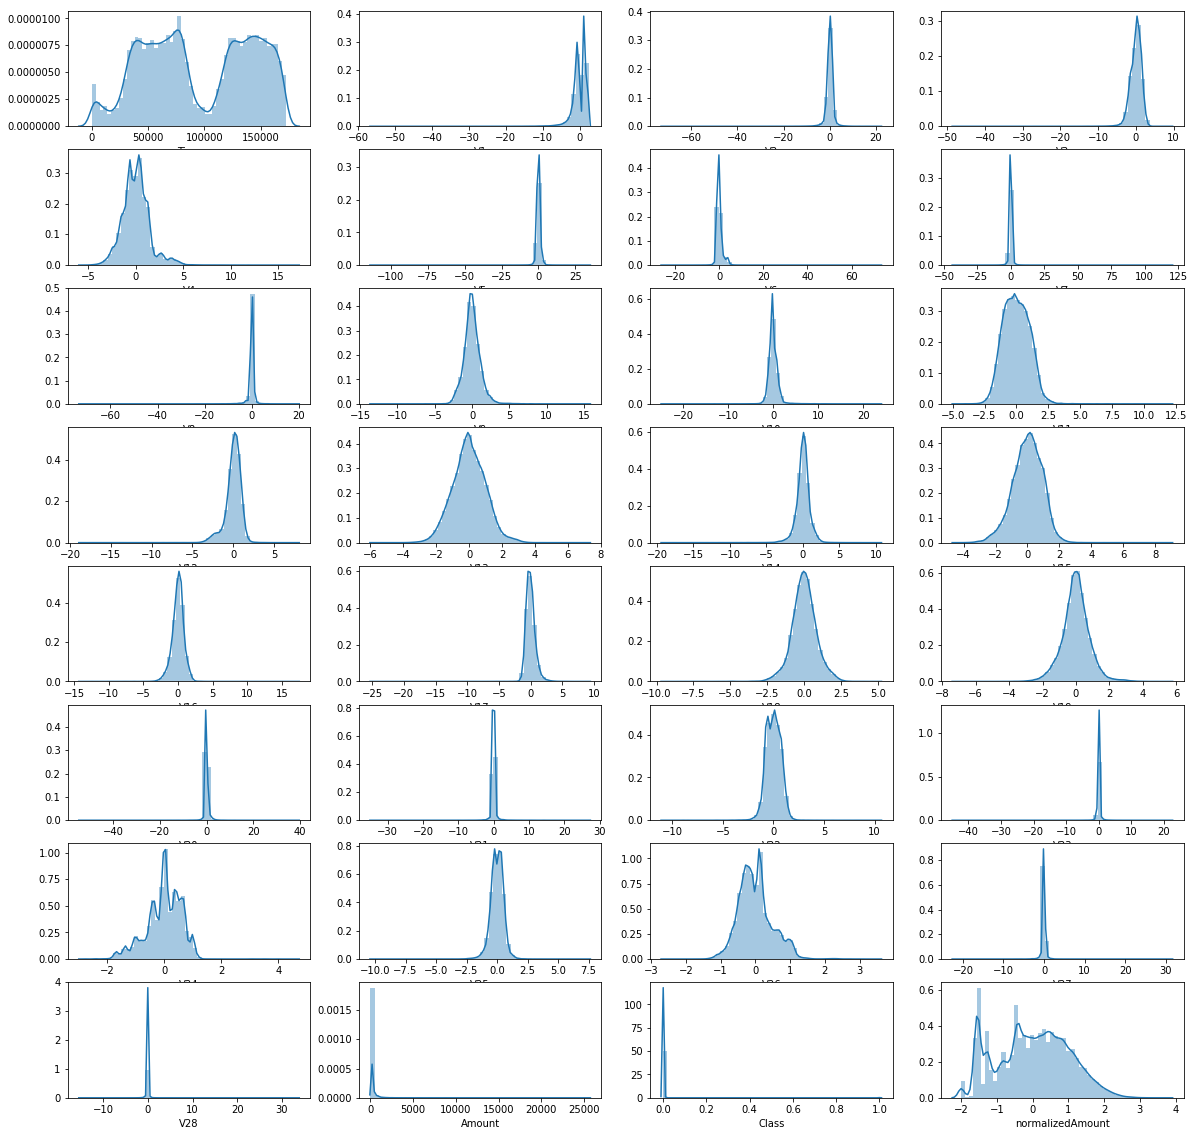

In [21]:
dims = (20, 20)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=dims)
for i, column in enumerate(data.columns):
    sns.distplot(data[column],ax=axes[i//4,i%4])

Our target is Class column.
Create an unsampled 

In [22]:
X = normalizedData.iloc[:, normalizedData.columns != 'Class']
y = normalizedData.iloc[:, normalizedData.columns == 'Class']
display(X.head())
display(y.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,normalizedAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.119013
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.128464
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.623286
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.012504
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.692981


,Class
0,0
1,0
2,0
3,0
4,0


### Applying SMOTE with Over Sampling

In [0]:
#Apply SMOTE to create synthetic observations from minority class
#Source:https://github.com/scikit-learn-contrib/imbalanced-learn
#https://beckernick.github.io/oversampling-modeling/

In [24]:
from imblearn.over_sampling import SMOTE #Over sampling
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_sample(X,y.values.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [25]:

display(X_smote.data.shape)
display(y_smote.data.shape)
display(X.shape)
display(y.shape)

(568630, 29)

(568630,)

(284807, 29)

(284807, 1)

We can see that in the oversampled data, the number of records has almost doubled

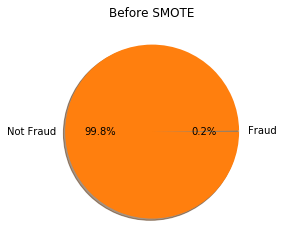

In [26]:
#Fraudulent data in the original data set
labels = ['Fraud', 'Not Fraud']
sizes = [data['Class'].value_counts()[1], data['Class'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Before SMOTE")
plt.show()

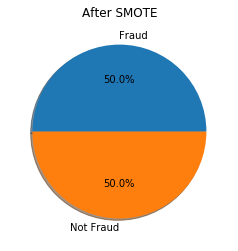

In [27]:
#frauduent data in the sampled data set
labels = ['Fraud', 'Not Fraud']
sizes = [len(y_smote[y_smote==1]),len(y_smote[y_smote==0])]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("After SMOTE")
plt.show()

After oversampling the class ratio is <b style="font-color:blue;">1.0</b>. We have a balanced dataset

#### Splitting data into train and test set.<b>

In [0]:
from sklearn.model_selection import train_test_split

##### Splitting original dataset

In [29]:
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, shuffle=True)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  227845
Number transactions test dataset:  56962
Total number of transactions:  284807


##### Splitting SMOTE dataset

In [0]:
# Over Sampled SMOTE dataset
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote
                                                                                   ,y_smote
                                                                                   ,test_size = 0.2
                                                                                   ,random_state = 42,
                                                                                   shuffle=True)

In [31]:
print("")
print("Number of transactions in training dataset: ", len(X_train_smote))
print("Number of transactions in test dataset: ", len(X_test_smote))
print("Total number of transactions: ", len(X_train_smote)+len(X_test_smote))


Number of transactions in training dataset:  454904
Number of transactions in test dataset:  113726
Total number of transactions:  568630


In [0]:
X_train_smote_df = pd.DataFrame(X_train_smote)
y_train_smote_df = pd.DataFrame(y_train_smote)
X_test_smote_df = pd.DataFrame(X_test_smote)
y_test_smote_df = pd.DataFrame(y_test_smote)

In [33]:
y_test_smote_df.describe()

,0
count,113726.000000
mean,0.500994
std,0.500001
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [0]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
import time

In [0]:
def train_evaluate_algorithm(learner,_parameters,X_train_,y_train_,X_test_,y_test_):
  # Make an fbeta_score scoring object using make_scorer()
  results = {}
  
  scorer = make_scorer(fbeta_score,beta=0.5)
  cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)
  # Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
  grid_obj = GridSearchCV(learner, _parameters, cv=cv_sets, scoring=scorer, verbose=0)

  # Fit the grid search object to the training data and find the optimal parameters using fit()
  start = time.time()
  grid_fit = grid_obj.fit(X_train_,y_train_)
  end = time.time()
  results['find_best_fit_time'] = end - start
  #grid_obj.fit(X_train_smote_df,y_train_smote_df.values.ravel())
  start = time.time()
  # Get the best estimator
  _best_clf = grid_fit.best_estimator_
  end = time.time()
  results['train_time'] = end - start
  # Make predictions
  #predictions = (clf.fit(X_train_smote_df, y_train_smote_df.values.ravel())).predict(X_test_smote_df)
  start = time.time()
  _best_predictions = _best_clf.predict(X_test_)
  end = time.time()
  results['pred_time'] = end - start
  results['best_classifier'] = _best_clf
  results['best_predictions'] = _best_predictions
  results['recall_score'] = recall_score(y_test_,_best_predictions)
  # Report the before-and-afterscores

  print("\nOptimized Model for learner {} = {}\n------".format(learner.__class__.__name__,_best_clf))
  print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_.values.ravel(),_best_predictions)))
  print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_.values.ravel(), _best_predictions, beta = 0.5)))
  print("Final Recall Score on the testing data: {:.4f}".format(results['recall_score']))

  print("Time to find the best fit  = {}Training Time = {} Prediction Time = {}"
        .format(results['find_best_fit_time'],results['train_time'],results['pred_time']))
  return results

In [0]:
#https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
#Reference implementatino for lgbm
import lightgbm as lgb

In [0]:
# specify your configurations as a dict
lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['l2', 'l1'],
    'num_leaves': [31],
    'learning_rate': [0.05],
    'feature_fraction':[ 0.8],
    'bagging_freq': [5],
    'verbose': [0]
    #'num_boost_round':[20,200,2000]
}

In [38]:
lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', 
                                    learning_rate=0.01, metric='auc')
lgb_results = train_evaluate_algorithm(lgb_estimator,lgb_params,X_train_smote_df,
                         y_train_smote_df.values.ravel(),
                        X_test_smote_df,y_test_smote_df)
print(lgb_results)


Optimized Model for learner LGBMClassifier = LGBMClassifier(bagging_freq=5, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='l2', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='regression', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)
------
Final accuracy score on the testing data: 0.9949
Final F-score on the testing data: 0.9951
Final Recall Score on the testing data: 0.9946
Time to find the best fit  = 72.94215059280396Training Time = 4.76837158203125e-07 Prediction Time = 0.4471259117126465
{'find_best_fit_time': 72.94215059280396, 'train_time': 4.76837158203125e-07, 'pred_time': 0.4471259117126465, 'best_classifier':

# **Logistic regression classifier**

Next step we create a base line model. <br>
We use LogisticRegression for baselining,as it is the go to model for the problem we have at hand. i.e a binary classification.<br>
There are multiple parameter which we can use to tune. However for the interest of time I am only going to evaluate for different values of the <b>''C''</b> or the inverse regularization strength.<br>

We are going to use l2 regularization for penalty as it is supported by most solvers.
Also in the next versions of sklearn  lbfgs is going to be the default. Hence using lbfgs as the solver parameter based on the warnings. I did try with 'sag'and 'saga'', but both of them were taking too much time and eventually timing out in the colab environment. <br>


In [0]:
from sklearn.linear_model import LogisticRegression

In [40]:

# : Initialize the classifier
lr_clf = LogisticRegression(max_iter = 1000, random_state=42,verbose=2,
                            penalty='l2')
c_param_range = [0.01,0.1,1,10,100]

lr_parameters = {'C':c_param_range, 'penalty': ['l2'],'solver':['lbfgs']}

lr_results = train_evaluate_algorithm(lr_clf,lr_parameters,X_train_smote_df,
                         y_train_smote_df.values.ravel(),
                        X_test_smote_df,y_test_smote_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work


Optimized Model for learner LogisticRegression = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=2,
                   warm_start=False)
------
Final accuracy score on the testing data: 0.9454
Final F-score on the testing data: 0.9619
Final Recall Score on the testing data: 0.9151
Time to find the best fit  = 106.79274773597717Training Time = 9.5367431640625e-07 Prediction Time = 0.010259628295898438


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


## RoC v Precision Recall
We now test the model how it evaluates against, the test data set, which we extracted from both the oversampled SMOTE and the original normalized data set.

We are going to evaluate the model agains two metrics. Receiver Operating characteristics aka ROC, and the Precision Recall Curve. For biased data sets Precision Recall Curve tend to be more reliable.
Using the area under the curve for the metrices we will put this theory to test.

The concepts are well expalined in this article.
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Please refer for detailed explanation

In [0]:
def plot_roc_curve(_title,X_test_,y_true_,y_pred_):
  # Plot ROC
  fpr, tpr, thresholds = roc_curve(y_true=y_true_, y_score=y_pred_)
  roc_auc = auc(fpr,tpr)
  plt.title(_title)
  auc_label="AUC = %0.2f"%(roc_auc)
  plt.plot(fpr, tpr, 'b',label=auc_label)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.1,1.0])
  plt.ylim([-0.1,1.01])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

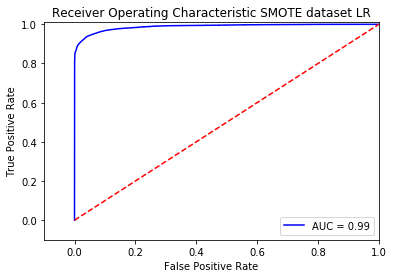

In [42]:
lr_best_fit = lr_results['best_classifier']
lr_smote_y_pred_score=lr_best_fit.decision_function(X_test_smote_df)
plot_roc_curve('Receiver Operating Characteristic SMOTE dataset LR'
               ,X_test_smote_df,y_test_smote_df,lr_smote_y_pred_score)

Test against the actual normalised data set

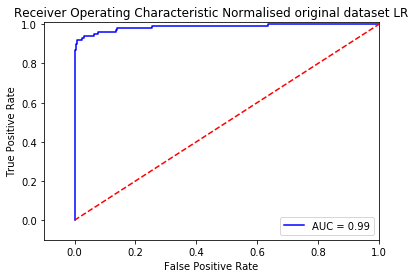

In [43]:
lr_orig_y_pred_score=lr_best_fit.decision_function(X_test)
plot_roc_curve('Receiver Operating Characteristic Normalised original dataset LR'
               ,X_test,y_test
               ,lr_orig_y_pred_score
              )

In [0]:
import matplotlib.patches as mpatches

In [0]:
def plot_precision_recall_curve(_title,y_true_,_probs):
  precision, recall, thresholds = precision_recall_curve(y_true_, _probs)
  auc_precisionrecall = auc(recall, precision)
  plt.title(_title)
  plt.plot([0, 1], [0.5, 0.5], linestyle='--')
  red_patch = mpatches.Patch(color='red', label = 'AUC = %0.2f'%auc_precisionrecall)
  plt.legend(handles=[red_patch])
  # plot the precision-recall curve for the model
  plt.plot(recall, precision, marker='.')
  plt.ylabel('precision')
  plt.xlabel('recall')
  # show the plot
  plt.show()


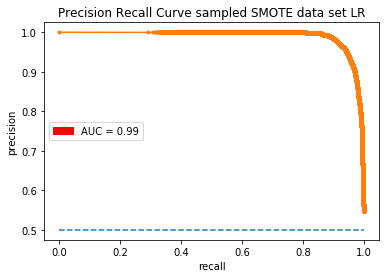

In [46]:
lr_smote_probs  = lr_best_fit.predict_proba(X_test_smote_df)
lr_smote_probs = lr_smote_probs[:,1]
plot_precision_recall_curve("Precision Recall Curve sampled SMOTE data set LR"
                            ,y_test_smote_df,lr_smote_probs)
#lr_smote_probs  = best_fit.predict_proba(X_test_smote_df)
#lr_smote_probs = lr_smote_probs[:,1]
#precision, recall, thresholds = precision_recall_curve(y_test_smote_df, lr_smote_probs)
#auc_precisionrecall = auc(recall, precision)
#plt.title()


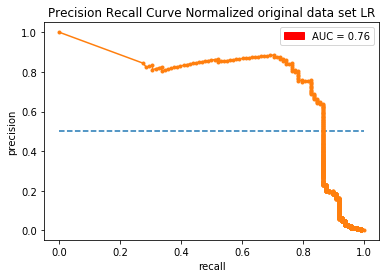

In [47]:
lr_original_probs  = lr_best_fit.predict_proba(X_test)
lr_original_probs = lr_original_probs[:,1]
plot_precision_recall_curve("Precision Recall Curve Normalized original data set LR"
                      ,y_test,lr_original_probs)


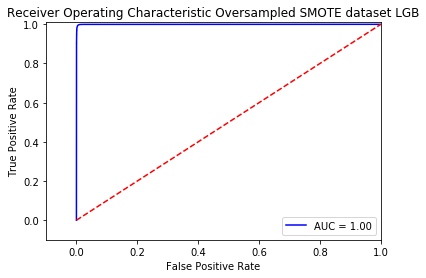

In [48]:
lgb_best_fit = lgb_results['best_classifier']
lgb_smote_y_pred_score = lgb_best_fit.predict_proba(X_test_smote_df)[:, 1]
plot_roc_curve('Receiver Operating Characteristic Oversampled SMOTE dataset LGB'
               ,X_test_smote_df,y_test_smote_df,lgb_smote_y_pred_score)

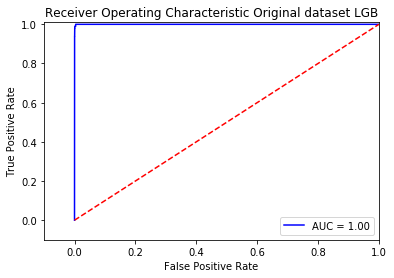

In [49]:
lgb_best_fit = lgb_results['best_classifier']
lgb_orig_y_pred_score = lgb_best_fit.predict_proba(X_test)[:, 1]
plot_roc_curve('Receiver Operating Characteristic Original dataset LGB'
               ,X_test,y_test,lgb_orig_y_pred_score)

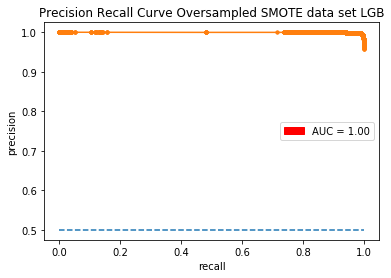

In [50]:
lgb_smote_probs  = lgb_best_fit.predict_proba(X_test_smote_df)
lgb_smote_probs = lgb_smote_probs[:,1]
plot_precision_recall_curve("Precision Recall Curve Oversampled SMOTE data set LGB"
                            ,y_test_smote_df,lgb_smote_probs)

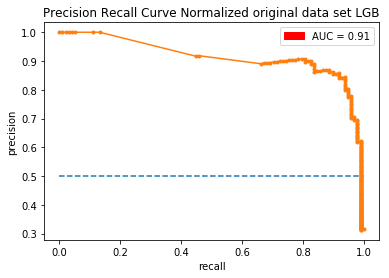

In [51]:
lgb_original_probs  = lgb_best_fit.predict_proba(X_test)
lgb_original_probs = lgb_original_probs[:,1]
plot_precision_recall_curve("Precision Recall Curve Normalized original data set LGB"
                      ,y_test,lgb_original_probs)

The precision recall curve shows, why accuracy or RoC is not a good metric for this data set. 
For both Logistic Regression and Light Gradient Boost, the results for accuracy, RoC and Precision/Recall are very similar
The area under the curve  of 0.76 for the precision recall curve is not acceptable. The model has high precision but poor recall, or vice verca. We need to tune the model. In the next sections we will evaluate, CNN and evaluate it against same metrics

# Using Convolutional Neural Networks

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [53]:
clf = Sequential([
    Dense(units=16, kernel_initializer='uniform', input_dim=29, activation='relu'),
    Dense(units=18, kernel_initializer='uniform', activation='relu'),
    Dropout(rate=0.25),
    Dense(20, kernel_initializer='uniform', activation='relu'),
    Dense(24, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

W0616 18:23:03.277798 140238093121408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 18:23:03.330460 140238093121408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 18:23:03.340377 140238093121408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 18:23:03.382372 140238093121408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0616 18:23:03.396274 

In [54]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,695
Trainable params: 1,695
Non-trainable params: 0
_________________________________________________________________


In [55]:
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W0616 18:23:03.482368 140238093121408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 18:23:03.520951 140238093121408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0616 18:23:03.528617 140238093121408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [56]:
start = time.time()
clf.fit(X_train_smote_df,y_train_smote_df.values.ravel(), batch_size=15, epochs=30)
end=time.time()

Epoch 1/30
454904/454904 [==============================] - 47s 102us/step - loss: 0.0380 - acc: 0.9867
Epoch 2/30
454904/454904 [==============================] - 46s 102us/step - loss: 0.0184 - acc: 0.9948
Epoch 3/30
454904/454904 [==============================] - 47s 103us/step - loss: 0.0141 - acc: 0.9963
Epoch 4/30
454904/454904 [==============================] - 46s 102us/step - loss: 0.0121 - acc: 0.9969
Epoch 5/30
454904/454904 [==============================] - 47s 103us/step - loss: 0.0109 - acc: 0.9973
Epoch 6/30
454904/454904 [==============================] - 47s 104us/step - loss: 0.0097 - acc: 0.9977
Epoch 7/30
454904/454904 [==============================] - 47s 103us/step - loss: 0.0096 - acc: 0.9977
Epoch 8/30
454904/454904 [==============================] - 47s 103us/step - loss: 0.0088 - acc: 0.9980
Epoch 9/30
454904/454904 [==============================] - 46s 102us/step - loss: 0.0084 - acc: 0.9981
Epoch 10/30
454904/454904 [==============================] - 47s

In [57]:
print("Time take to fit and get the best model = {}".format(end - start))

Time take to fit and get the best model = 1406.1895444393158


In [58]:
score = clf.evaluate(X_test_smote_df, y_test_smote_df.values.ravel(), batch_size=10)
print('\nAnd the Score is ', score[1] * 100, '%')

113726/113726 [==============================] - 7s 63us/step

And the Score is  99.90943141888651 %


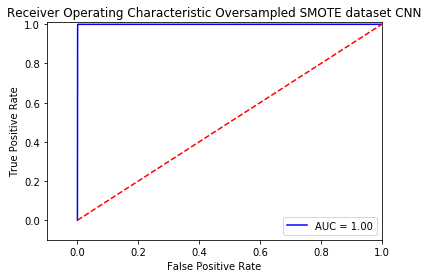

In [59]:
cnn_smote_y_pred_score = clf.predict_proba(X_test_smote_df).ravel()
plot_roc_curve('Receiver Operating Characteristic Oversampled SMOTE dataset CNN'
               ,X_test_smote_df,y_test_smote_df,cnn_smote_y_pred_score)

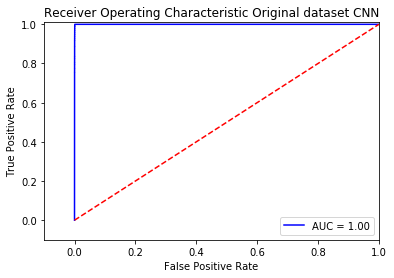

In [60]:
cnn_orig_y_pred_score = clf.predict_proba(X_test).ravel()
plot_roc_curve('Receiver Operating Characteristic Original dataset CNN'
               ,X_test,y_test,cnn_orig_y_pred_score)

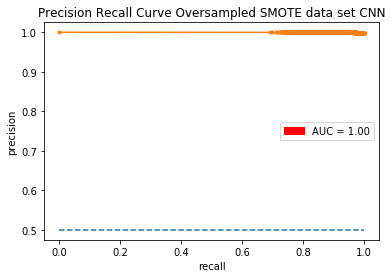

In [61]:
cnn_smote_probs = clf.predict_proba(X_test_smote_df)
plot_precision_recall_curve("Precision Recall Curve Oversampled SMOTE data set CNN"
                            ,y_test_smote_df,cnn_smote_probs)

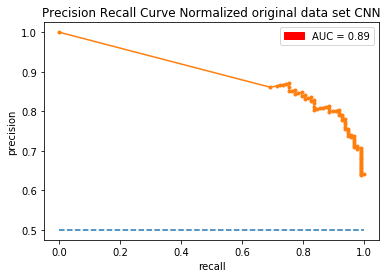

In [62]:
cnn_original_probs = clf.predict_proba(X_test)
plot_precision_recall_curve(
    "Precision Recall Curve Normalized original data set CNN"
                      ,y_test,cnn_original_probs)

While the AUC for LGB is higher for precision recall curve, the performance of CNN is better and the precision never drops of sharply as the recall is increased